# Generate .tp5 for SeeBor profiles

In [1]:
# read SeeBor profiles
import numpy as np
from tqdm import tqdm
from read_profiles import *

file_path = r'E:\data\atm_profile\SeeBor.bin'
tem, h2o, o3, tpw, fraction_land, h = Read_Seebor(file_path)
h2o *= 1e3 # kg/kg -> g/kg
idx_land = np.where(fraction_land > 0.5)[0]
num = len(idx_land)
tem_selected, h2o_selected, o3_selected, tpw_selected, h_selected = tem[idx_land, :], h2o[idx_land, :], o3[idx_land, :], tpw[idx_land], h[idx_land]

In [3]:
# generate .tp5 file
from create_cards import *

H1 = 407 # altitude of ECOSTRESS sensor (km)
VZA = 53
V1, V2, DV, FWHM = 750, 1450, 1, 1
XFLAG = 'W'
FLAGS = '      F'
# V1, V2, DV, FWHM = 7, 13, 0.02, 0.02 # FWHM must be larger than 0.016 um
# XFLAG = 'M'
# FLAGS = 'MRAA  F'
card1 = create_card1()
card1a = create_card1a()
card3 = create_card3(H1, VZA)
card4 = create_card4(V1, V2, DV, FWHM, XFLAG, FLAGS)

tp5_save_path = f'../tp5/ECOSTRESS_{VZA:2d}.tp5'
with open(tp5_save_path, "w") as f:
    for i in tqdm(range(num)):
        card2 = create_card2(GNDALT=h_selected[i])
        card2c_i, card2c1_i = create_card2c(P=pressure_seebor, T=tem_selected[i,:], H20=h2o_selected[i,:], O3=o3_selected[i,:])
        if i==num:
            IRPT = 0
        else:
            IRPT = -1
        card5 = create_card5(IRPT)

        f.write(card1 + '\n')
        f.write(card1a + '\n')
        f.write(card2 + '\n')
        f.write(card2c_i + '\n')
        for str in card2c1_i:
            f.write(str + '\n')
        f.write(card3 + '\n')
        f.write(card4 + '\n')
        f.write(card5 + '\n')
        
f.close()

100%|██████████| 9136/9136 [00:03<00:00, 2882.62it/s]


# Read output files (.tp7 and .7sc)

In [9]:
# interpolate SRF of ECOSTRESS
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

file_srf = r'E:\data\srf\20180318-ECOSTRESS_SRF_v3.xlsx'
df = pd.read_excel(file_srf)
lamda_srf, srf = df.iloc[:, 0].values, df.iloc[:, 1:].values
wn_srf = 1e4 / lamda_srf
wn_itp = np.arange(770, 1427, 1)
num_channel = 5

srf_itp = np.zeros((len(wn_itp), num_channel))
for i in range(num_channel):
    f_srf = interp1d(wn_srf, srf[:, i], kind='cubic')
    srf_itp[:, i] = f_srf(wn_itp)

In [3]:
from read_outputs import *
# Read .tp7 and .flx, then extract atmospheric paramters
tp7_path = r'F:\result\SW_TES/ECOSTRESS.tp7'
flx_path = r'F:\result\SW_TES/ECOSTRESS.flx'

wn, tran, L_up, L_dn = Read_tp7(tp7_path, ref=0.05)
SDLR = Read_flx(flx_path, len(tran))

Text(0, 0.5, '$L_{dn}$ from flx (W/m$^2$/sr/cm$^{-1}$)')

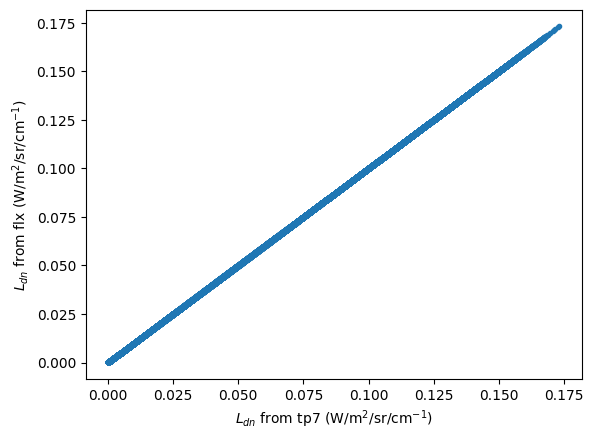

In [111]:
# d = L_dn * np.pi - SDLR
idx = (tran>1e-6)
import matplotlib.pyplot as plt
plt.scatter(L_dn[idx], SDLR[idx]/np.pi, marker='.')
plt.xlabel('$L_{dn}$ from tp7 (W/m$^2$/sr/cm$^{-1}$)')
plt.ylabel('$L_{dn}$ from flx (W/m$^2$/sr/cm$^{-1}$)')

In [6]:
# calculate channel parameters
idx_s, idx_e = np.where(wn==np.min(wn_itp))[0][0], np.where(wn==np.max(wn_itp))[0][0]
tran_sub, L_up_sub, L_dn_sub = tran[:, idx_s:idx_e+1], L_up[:, idx_s:idx_e+1], SDLR[:, idx_s:idx_e+1] / np.pi

tran_mod, L_up_mod, L_dn_mod = np.zeros((len(tran_sub), num_channel)), np.zeros((len(tran_sub), num_channel)), np.zeros((len(tran_sub), num_channel))
for i in range(num_channel):
    tran_mod[:, i] = np.sum(tran_sub * srf_itp[:, i], axis=1) / np.sum(srf_itp[:, i])
    L_up_mod[:, i] = np.sum(L_up_sub * srf_itp[:, i], axis=1) / np.sum(srf_itp[:, i])
    L_dn_mod[:, i] = np.sum(L_dn_sub * srf_itp[:, i], axis=1) / np.sum(srf_itp[:, i])

In [7]:
# read rttov results at nadir
tran_rttov = np.load(r'F:\result\SW_TES\atm_params\tran_00.npy')
L_up_rttov = np.load(r'F:\result\SW_TES\atm_params\Lup_00.npy')
L_up_rttov /= 1e3
L_dn_rttov = np.load(r'F:\result\SW_TES\atm_params\Ldn_53.npy')
L_dn_rttov /= 1e3

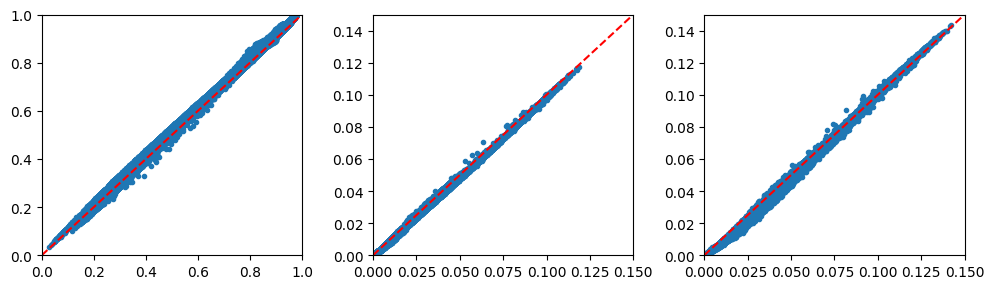

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].scatter(tran_mod.flatten(), tran_rttov.flatten(), marker='.')
axs[0].plot([0, 1], [0, 1], 'r--')
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])

axs[1].scatter(L_up_mod.flatten(), L_up_rttov.flatten(), marker='.')
axs[1].plot([0, 0.15], [0, 0.15], 'r--')
axs[1].set_xlim([0, 0.15])
axs[1].set_ylim([0, 0.15])

axs[2].scatter(L_dn_mod.flatten(), L_dn_rttov.flatten(), marker='.')
axs[2].plot([0, 0.15], [0, 0.15], 'r--')
axs[2].set_xlim([0, 0.15])
axs[2].set_ylim([0, 0.15])

plt.tight_layout()